In [79]:
import pandas as pd
import pandas as pd
import copy
import random as rd
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt 
import math
from matplotlib import font_manager

fontP = font_manager.FontProperties()
fontP.set_family('SimHei')
fontP.set_size(14)

In [13]:
#!/ usr/bin/python
# -*- coding:utf-8 -*-
import matplotlib.pyplot as plt
import math


def dcm2dgr(a):#大地坐标经纬度小数表示转度数表示
    x = int(a)
    tmpy = a-x
    y = int(tmpy*60)
    tmpz = tmpy*60 - y
    z = tmpz*60
    return (x,y,z)
def dgr2dcm(a):#大地坐标经纬度度数表示转小数表示
    x,y,z = a
    return x+y/60+z/3600


def XY2LatLon(X, Y, L0=42+39):#+39变成6度投影

    iPI = 0.0174532925199433
    a = 6378137.0
    f= 0.00335281006247
    ZoneWide = 3 #按3度带进行投影

    ProjNo = int(X / 1000000)
    L0 = L0 * iPI
    X0 = ProjNo * 1000000 + 500000
    Y0 = 0
    xval = X - X0
    yval = Y - Y0

    e2 = 2 * f - f * f #第一偏心率平方
    e1 = (1.0 - math.sqrt(1 - e2)) / (1.0 + math.sqrt(1 - e2))
    ee = e2 / (1 - e2) #第二偏心率平方

    M = yval
    u = M / (a * (1 - e2 / 4 - 3 * e2 * e2 / 64 - 5 * e2 * e2 * e2 / 256))

    fai = u \
          + (3 * e1 / 2 - 27 * e1 * e1 * e1 / 32) * math.sin(2 * u) \
          + (21 * e1 * e1 / 16 - 55 * e1 * e1 * e1 * e1 / 32) * math.sin(4 * u) \
          + (151 * e1 * e1 * e1 / 96) * math.sin(6 * u)\
          + (1097 * e1 * e1 * e1 * e1 / 512) * math.sin(8 * u)
    C = ee * math.cos(fai) * math.cos(fai)
    T = math.tan(fai) * math.tan(fai)
    NN = a / math.sqrt(1.0 - e2 * math.sin(fai) * math.sin(fai))
    R = a * (1 - e2) / math.sqrt(
        (1 - e2 * math.sin(fai) * math.sin(fai)) * (1 - e2 * math.sin(fai) * math.sin(fai)) * (1 - e2 * math.sin(fai) * math.sin(fai)))
    D = xval / NN

    #计算经纬度（弧度单位的经纬度）
    longitude1 = L0 + (D - (1 + 2 * T + C) * D * D * D / 6 + (
    5 - 2 * C + 28 * T - 3 * C * C + 8 * ee + 24 * T * T) * D * D * D * D * D / 120) / math.cos(fai)
    latitude1 = fai - (NN * math.tan(fai) / R) * (
    D * D / 2 - (5 + 3 * T + 10 * C - 4 * C * C - 9 * ee) * D * D * D * D / 24 + (
    61 + 90 * T + 298 * C + 45 * T * T - 256 * ee - 3 * C * C) * D * D * D * D * D * D / 720)

    #换换为deg
    longitude = longitude1 / iPI
    latitude = latitude1 / iPI

    return latitude, longitude


# LatLon2XY(40.07837722329, 116.23514827596)
# XY2LatLon(434760.7611718801, 4438512.040474475, 117.0)

x = 4311109.5
y = 14749903.4

tmp = XY2LatLon(y,x)
tmp

(38.89784353649511, 83.88044409462027)

In [21]:
pthLayerSeq = r'D:\workplace\geoproject\pictureproject\data\material\温度\地层层序-井深.xlsx'
dataLayerSeq= pd.read_excel(pthLayerSeq)
pthBaseInfo = r'D:\workplace\geoproject\pictureproject\data\material\温度\基本信息.xlsx'
dataBaseInfo= pd.read_excel(pthBaseInfo)

allTmprt = {}
for index, row in dataBaseInfo.iterrows():
    posWell = row['井位']
    hf = row['地表热流']
    gt = row['地表温度']

    pthStaticTmprt = r'D:\workplace\geoproject\pictureproject\data\material\温度\xlsx-静温\静温-%s.xlsx' % posWell
    staticTmprt = pd.read_excel( pthStaticTmprt )

    allTmprt[posWell] = staticTmprt 

In [18]:
# 根据距离找到K个相邻的位置
# 把目标井位的第i个深度对Kj个相邻井位求静温
# 平均这几个静温

def caldis(pos1, pos2):
    x = pos1[0]-pos2[0]
    y = pos1[1]-pos2[1]
    return math.sqrt( x*x+y*y )

X = []
trainX = []
trainXpos = []
validX = []
validXpos = []
Xpos = []
for index, row in dataBaseInfo.iterrows():
    posWell = row['井位']
    row = dataBaseInfo[ dataBaseInfo['井位']==posWell ]

    tarX = float( row['X'] )
    tarY = float( row['Y'] )

    tarpos = XY2LatLon( tarY, tarX)
    tarpos = (round(tarpos[0],6), round(tarpos[1], 6))

    X.append( posWell )
    Xpos.append( tarpos )

trainX.extend( X[0:len(X)-1])
trainXpos.extend( Xpos[0:len(Xpos)-1] )
validX.append( X[-1])
validXpos.append( Xpos[-1])

In [20]:
tarWell = validX[0]
tarpos = validXpos[0] 

In [76]:
K = 1

def guess(trainX, trainXpos, allTmprt, tarWell, tarpos, K):
    alldis = []
    for i in range(len(trainX)):
        apos = trainXpos[i]

        dis = caldis( tarpos, apos)
        alldis.append( dis )

    idx = sorted(range(len(alldis)), key=lambda k: alldis[k])
    kidx = idx[0:K]

    print(kidx)

    tarTmprt = allTmprt[tarWell].values


    lstTarTmprt = []
    for i in range( len(tarTmprt)-1 ):
        apos = tarTmprt[i][0]
        # print( apos )

        lsttmprt = []
        for i in kidx:
            wellName = trainX[i]
            wellPos = trainXpos[i]

            tmprt = allTmprt[wellName].values

            if apos < tmprt[0][0] or apos >tmprt[-1][0]:

                atmprt = tmprt[i][1]+ (apos-tmprt[-2][0])/(tmprt[-1][0]-tmprt[-2][0])* \
                        (tmprt[-1][1]-tmprt[-2][1])
                lsttmprt.append( atmprt )
                continue

            atmprt = 0
            for i in range( len(tmprt)-1 ):
                iL = i+1
                # print(i,iL)
                if apos>= tmprt[i][0] and apos<tmprt[iL][0]:
                    # print(tmprt[i][1], tmprt[i][0], tmprt[iL][0], tmprt[i][1], tmprt[iL][1])
                    atmprt = tmprt[i][1]+ (apos-tmprt[i][0])/(tmprt[iL][0]-tmprt[i][0])* \
                            (tmprt[iL][1]-tmprt[i][1])
                    
                    lsttmprt.append( atmprt )
                    break 
        if len(lsttmprt ) != K:
            print('aaaaaaaaaaaaaaaa')
            # print('not in range')
        aTarTmprt = sum( lsttmprt)/len( lsttmprt)
        lstTarTmprt.append( round(aTarTmprt, 2) )
    # print(lstTarTmprt )
    return lstTarTmprt

In [77]:


lstError = []
for i in range(1, 5):
    error = 0
    lstTarTmprt = guess(trainX, trainXpos, allTmprt, tarWell, tarpos,i)

    tarTmprt = allTmprt[tarWell].values
    
    for i in range( len(lstTarTmprt) ):
        guessTmprt = lstTarTmprt[i]
        realTmprt = tarTmprt[i][1]
        error += abs( guessTmprt-realTmprt )
    lstError.append( round(error,2) )
lstError

[0]
[0, 2]
[0, 2, 1]
[0, 2, 1, 3]


[39.57, 224.77, 223.36, 180.85]

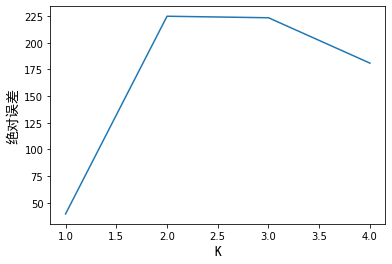

In [89]:
plt.plot( [k for k in range(1, len(lstError)+1)], lstError )
plt.xlabel('K',  FontProperties=fontP)
plt.ylabel('绝对误差',  FontProperties=fontP)
plt.show()

[0]


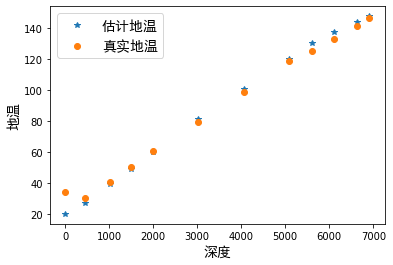

In [86]:
lstTarTmprt = guess(trainX, trainXpos, allTmprt, tarWell, tarpos,1)

realTmprt=[tarTmprt[i][1] for i in range(len(lstTarTmprt))]
dpth = [tarTmprt[i][0] for i in range(len(lstTarTmprt))]
plt.plot( dpth, lstTarTmprt,'*', label='估计地温')
plt.xlabel('深度',  FontProperties=fontP)
plt.ylabel('地温',  FontProperties=fontP)
plt.plot( dpth, realTmprt, 'o', label='真实地温' )
plt.legend( prop=fontP )
plt.show()

In [54]:
realTmprt

146.63